
# Climates like Flagstaff
The purpose of this analysis is to find climates like Flagstaff in other parts of the globe, preferably where the architecture isn't the result of recent colonization, and maybe also where the indigenous group is genetically similar to myself.

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py

s = Storage()


----
# Get the NOAA data

In [3]:

# Download the GNU zip file
from os.path import exists
import requests

gz_folder = '../saves/gz'
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-year/archive/gsoy-latest.tar.gz'
source_filename = url.split('/')[-1]
source_filepath = os.path.join(gz_folder, source_filename)
if not exists(source_filepath):
    os.makedirs(name=gz_folder, exist_ok=True)
    response = requests.get(url)
    with open(source_filepath, 'wb') as ibw:
        ibw.write(response.content)

In [4]:

# Write the tarball
import gzip

dest_filename = '.'.join(source_filename.split('.')[:-1])
tar_folder = '../saves/tar'
dest_filepath = os.path.join(tar_folder, dest_filename)
if not exists(dest_filepath):
    os.makedirs(name=tar_folder, exist_ok=True)
    with gzip.open(source_filepath, 'rb') as s_file, open(dest_filepath, 'wb') as d_file:
        while True:
            block = s_file.read(65_536)
            if not block:
                break
            else:
                d_file.write(block)

In [5]:

# Extract the CSVs
import tarfile

dest_folder = os.path.join(s.data_csv_folder, 'gsoy-latest')
if not exists(os.path.join(dest_folder, 'ACW00011647.csv')):
    os.makedirs(name=dest_folder, exist_ok=True)
    tar = tarfile.open(dest_filepath)
    tar.extractall(path=dest_folder)
    tar.close()

In [6]:

# Aggregate the CSVs and store them as a pickle and as a CSV
from tqdm.notebook import tqdm
tqdm.pandas()

if s.pickle_exists('climates_df'):
    climates_df = s.load_object('climates_df')
else:
    climates_df = pd.DataFrame([], columns=['csv_name'])
    csv_folder = os.path.join(s.data_csv_folder, 'gsoy-latest')
    csvs_list = [fn for fn in os.listdir(csv_folder) if fn.endswith('.csv')]
    for csv_name in tqdm(csvs_list):
        csv_path = os.path.join(csv_folder, csv_name)
        df = pd.read_csv(os.path.abspath(csv_path), encoding=s.encoding_type)
        df['csv_name'] = csv_name
        climates_df = pd.concat([climates_df, df], axis='index', ignore_index=True)
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)


----
# Add Elevation Difference from Flagstaff column

In [7]:

# Flagstaff is 2108 meters with elevation that is 1829 meters higher than average city elevation in United States.
# Scale of surrounding elevation is from 2068 to 2472 m with average elevation of 2150.3 meters.
if 'elevation_diff' not in climates_df.columns:
    climates_df['elevation_diff'] = climates_df.ELEVATION.map(lambda x: abs(x - 2108))
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df, verbose=True)


----
# Add Geodesic Distance to Flagstaff column

In [8]:

# Add column for distance to Flagstaff, AZ, USA
# Latitude and longitude coordinates are: 35.198284, -111.651299
import math
import numpy as np
from geopy.distance import distance

if 'distance_to_flagstaff' not in climates_df.columns:
    flagstaff_az = (-35.198284, 111.651299)
    def f(row_series):
        distance_to_flagstaff = np.nan
        latitude = row_series.LATITUDE
        longitude = row_series.LONGITUDE
        if (str(latitude) != 'nan') and (str(longitude) != 'nan'):
            lat_lon_tuple = (latitude, longitude)
            distance_to_flagstaff = distance(flagstaff_az, lat_lon_tuple).km

        return distance_to_flagstaff
    climates_df['distance_to_flagstaff'] = climates_df.progress_apply(f, axis='columns')
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df, verbose=True)


# Use Random Forest to get the Features that are important to being nearby Flagstaff

In [9]:

# Figure out which observations we know for sure are the same climate as Flagstaff
def f(x):
    
    return 'flagstaff' in str(x).lower()
mask_series = climates_df.NAME.map(f)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
climates_df[mask_series][columns_list].sort_values('distance_to_flagstaff').head(200).tail(20)

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
1635387,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635385,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635384,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635383,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635389,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635426,0.130167,US1AZCN0092,"FLAGSTAFF 8.2 NE, AZ US",35.268021,-111.541389,2041.9
1635425,0.130167,US1AZCN0092,"FLAGSTAFF 8.2 NE, AZ US",35.268021,-111.541389,2041.9
1635433,0.147351,US1AZCN0140,"FLAGSTAFF 9.8 NNE, AZ US",35.309071,-111.554146,2088.5
1635434,0.147351,US1AZCN0140,"FLAGSTAFF 9.8 NNE, AZ US",35.309071,-111.554146,2088.5
1635435,0.185256,US1AZCN0154,"FLAGSTAFF 10.5 E, AZ US",35.217705,-111.467064,1967.5


In [10]:

# Check observations close to Flagstaff without being explicitly named
def f(x):
    
    return 'flagstaff' in str(x).lower()
mask_series = (climates_df.distance_to_flagstaff < 0.2) & ~climates_df.NAME.map(f)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
climates_df[mask_series][columns_list].sort_values('distance_to_flagstaff')

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
2418721,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418733,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418732,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418731,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418730,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
...,...,...,...,...,...,...
1695078,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695079,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695080,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695070,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9


In [11]:

# Get list of stations nearby Flagstaff
if s.pickle_exists('flagstaff_nearby_list'):
    nearby_list = s.load_object('flagstaff_nearby_list')
else:
    climates_df = climates_df.reset_index(drop=True)
    nearby_list = climates_df[climates_df.distance_to_flagstaff < 0.2].index.tolist()
    s.store_objects(flagstaff_nearby_list=nearby_list)

In [12]:

# Get numeric columns
%run ../load_magic/dataframes.py

if s.pickle_exists('climates_numeric_columns_list'):
    numeric_columns_list = s.load_object('climates_numeric_columns_list')
else:
    get_column_descriptions_df = get_column_descriptions(climates_df.sample(min(5_000, climates_df.shape[0])))
    mask_series = ~get_column_descriptions_df.column_name.isin(['distance_to_flagstaff', 'LONGITUDE', 'LATITUDE', 'elevation_diff', 'DATE', 'index'])
    mask_series = mask_series & get_column_descriptions_df.dtype.isin(['int64', 'float64']) & (get_column_descriptions_df.count_uniques > 2)
    df = get_column_descriptions_df[mask_series].sort_values(['count_uniques'], ascending=[False])
    numeric_columns_list = df.column_name.tolist()
    s.store_objects(climates_numeric_columns_list=numeric_columns_list)
    display(df)

In [13]:

# Show columns important for determining if like Flagstaff
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

if s.pickle_exists('flagstaff_feature_importances_tuples_list'):
    feature_importances_tuples_list = s.load_object('flagstaff_feature_importances_tuples_list')
else:
    
    # Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values)
    # feature_importances_tuples_list = sorted([(cn, ci) for cn, ci in zip(numeric_columns_list, rfclf.feature_importances_) if ci > 0.0],
    #                                          key=lambda x: x[1], reverse=True)[:6]
    # print(feature_importances_tuples_list)
    
    X = climates_df[numeric_columns_list].fillna(0).values
    y = climates_df.index.isin(nearby_list)
    
    # Create the Random Forest Classifier
    if s.pickle_exists('climates_rfclf'):
        rfclf = s.load_object('climates_rfclf')
    else:
        rfclf = RandomForestClassifier()
        rfclf.fit(X, y)
        s.store_objects(climates_rfclf=rfclf)
    
    result = permutation_importance(rfclf, X, y, n_repeats=10)
    feature_importances_tuples_list = sorted([(cn, ci) for cn, ci in zip(numeric_columns_list, result.importances_mean)], key=lambda x: x[1], reverse=True)[:6]
    s.store_objects(flagstaff_feature_importances_tuples_list=feature_importances_tuples_list)
print(feature_importances_tuples_list)

[('ELEVATION', 0.000182097379708257), ('DT32', 8.42623284901367e-05), ('TMAX', 5.8788596683967406e-05), ('PRCP', 3.482736770377137e-05), ('HTDD', 3.0409267343634026e-05), ('EMXP', 2.9772424048468694e-05)]



# Use the Nearby Minimum and Maximum of the Important Features to create the is-like-Flagstaff Column

In [14]:

columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
if 'is_like_flagstaff' not in climates_df.columns:
    mask_series = climates_df.index.isin(nearby_list)
    df = climates_df[mask_series][columns_list].describe()
    mask_series = True
    for column_name in columns_list:
        mask_series = mask_series & (climates_df[column_name] >= df.loc['min', column_name]) & (climates_df[column_name] <= df.loc['max', column_name])
    climates_df['is_like_flagstaff'] = False
    climates_df.loc[mask_series, 'is_like_flagstaff'] = True
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df, verbose=True)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE'] + columns_list
climates_df[climates_df.is_like_flagstaff][columns_list].sample(20).sort_values('distance_to_flagstaff')

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DT32,TMAX,PRCP,HTDD,EMXP
1699666,2.494240,USC00023683,"GREER, AZ US",34.021900,-109.451900,2522.2,217.0,14.05,612.6,4616.9,27.7
2067888,3.505575,USC00298834,"THOREAU 12 SE, NM US",35.300000,-108.147200,2263.1,197.0,16.92,290.9,3944.0,35.6
1767836,4.134102,USC00053016,"FORT LEWIS, CO US",37.230900,-108.051400,2320.7,212.0,15.14,241.4,4307.7,17.5
2059493,4.413382,USC00293951,"HERMOSA, NM US",33.166670,-107.733330,2011.7,189.0,17.05,237.0,3655.4,21.6
1770661,4.467230,USC00054250,"IGNACIO 1 N, CO US",37.136390,-107.626390,1969.0,232.0,16.55,322.9,NaN,33.8
2036585,4.586303,USC00264514,"GREAT BASIN NATIONAL PARK, NV US",39.000000,-114.216670,2080.6,177.0,16.07,373.6,3599.1,39.4
2422677,5.079540,USS0014K02S,"BERRY CREEK, NV US",39.320000,-114.620000,2773.7,200.0,9.72,672.0,5263.2,25.4
2417614,5.672132,USS0011J37S,"HARDSCRABBLE, UT US",40.870000,-111.720000,2209.8,140.0,13.42,873.0,NaN,63.5
2066564,5.738502,USC00298086,"SANTA FE FIELD STATION, NM US",35.683333,-105.933333,2133.6,156.0,16.66,406.4,3535.1,40.9
2054761,6.824497,USC00291813,"CIMARRON 4 SW, NM US",36.466100,-104.945600,1993.4,147.0,18.53,307.3,3148.7,28.2



# Add a Wikipedia URL Column

In [15]:

import wikipedia
import numpy as np
from wikipedia.exceptions import (PageError, DisambiguationError, WikipediaException)
from IPython.display import clear_output
from time import sleep

if ('wikipedia_url' not in climates_df.columns) or climates_df.wikipedia_url.isnull().all():
    mask_series = climates_df.is_like_flagstaff & climates_df.wikipedia_url.isnull()
    for row_index, row_series in climates_df[mask_series].iterrows():
        latitude = row_series.LATITUDE
        longitude = row_series.LONGITUDE
        titles_list = wikipedia.geosearch(latitude=latitude, longitude=longitude, radius=10_000)
        if titles_list:
            try:
                wikipedia_url = wikipedia.page(title=titles_list[0]).url
                climates_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
                clear_output(wait=True)
                print(f'{row_series.NAME}: {wikipedia_url}')
            except (PageError, DisambiguationError) as e:
                clear_output(wait=True)
                print(f'{row_series.NAME}: {str(e).strip()}')
            except (WikipediaException) as e:
                clear_output(wait=True)
                print(f'{row_series.NAME}: {str(e).strip()}')
                sleep(60)
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)


# Display the farthest away Flagstaff-like Weather Stations

In [16]:

columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'wikipedia_url'] + [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
mask_series = climates_df.is_like_flagstaff
df = climates_df[mask_series][columns_list].sort_values('NAME')
mask_series = (df.NAME.shift(-1) != df.NAME)
df[mask_series].sort_values('distance_to_flagstaff', ascending=False).head(20)

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,wikipedia_url,ELEVATION,DT32,TMAX,PRCP,HTDD,EMXP
909546,215.233385,CHM00056182,"SONGPAN, CH",32.65000,103.56700,https://en.wikipedia.org/wiki/Songpan_County,2852.0,160.0,15.53,586.9,3608.5,29.5
909110,214.551391,CHM00056080,"HEZUO, CH",35.00000,102.90000,https://en.wikipedia.org/wiki/Hezuo,2910.0,226.0,10.61,590.9,5461.0,39.8
909482,213.909729,CHM00056172,"BARKAM, CH",31.90000,102.23300,https://en.wikipedia.org/wiki/Barkam,2666.0,139.0,19.42,588.8,2754.5,21.9
904622,213.423014,CHM00052866,"XINING, CH",36.61700,101.76700,https://en.wikipedia.org/wiki/Xining,2296.0,179.0,12.70,352.9,NaN,32.6
1183854,187.754848,KG000036974,"NARYN, KG",41.43310,76.00000,https://en.wikipedia.org/wiki/Naryn,2041.0,167.0,11.17,246.1,5158.0,9.7
1611693,183.165762,TI000038954,"KHOROG, TI",37.50000,71.50000,https://en.wikipedia.org/wiki/Khorugh,2077.0,141.0,14.44,441.9,3673.4,27.3
1544781,114.033080,SPE00156387,"NURIA, SP",42.38170,2.15530,https://en.wikipedia.org/wiki/Vall_de_N%C3%BAria,1971.0,162.0,10.19,762.6,4519.2,46.8
1544714,113.661978,SPE00156333,"MALNIU, SP",42.46580,1.77810,NaN,2230.0,151.0,9.66,1000.9,4492.6,48.6
2099526,29.372843,USC00315922,"MOUNT MITCHELL 2 SSW, NC US",35.73333,-82.28333,NaN,1991.9,153.0,9.63,1249.1,4878.2,68.6
1287517,21.655098,MXN00021031,"CUESTA BLANCA, MX",18.85000,-97.45000,NaN,2383.8,158.0,15.05,479.1,3918.7,50.5



<img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/Sierra_Madre.jpg" width="100%" />


# Make a Bounding Box around Europe

In [17]:

westernmost_longitude = -9.500556
easternmost_longitude = 66.618056
northernmost_latitude = 71.133889
southernmost_latitude = 36
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'elevation_diff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,elevation_diff,wikipedia_url
1544786,SPE00156387,"NURIA, SP",42.3817,2.1553,1971.0,114.033080,137.0,https://en.wikipedia.org/wiki/Vall_de_N%C3%BAria
1544714,SPE00156333,"MALNIU, SP",42.4658,1.7781,2230.0,113.661978,122.0,NaN



----
# Check if there exists some Clustering Algorithm that naturally bunches those weather stations near Flagstaff

In [18]:

from functools import partial
from sklearn import manifold
from collections import OrderedDict
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA

# Set-up manifold methods
n_neighbors = 10
n_components = 2
LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver='auto',
)

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa', eigen_solver='dense')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors
)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
methods['Incremental PCA'] = IncrementalPCA(n_components=n_components, batch_size=10)
methods['PCA'] = PCA(n_components=n_components)
methods['Kernel PCA'] = KernelPCA(kernel='rbf', fit_inverse_transform=True, gamma=10)
methods['Truncated SVD'] = TruncatedSVD(n_components=n_components)
methods['Factor Analysis'] = FactorAnalysis(n_components=n_components)
methods['Fast ICA'] = FastICA(n_components=n_components)

C:\Users\daveb\AppData\Local\Temp\ipykernel_10120\699047002.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(climates_df[~mask_series][columns_list].sample(sample_size - df.shape[0]))


Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved. In that case, eigen_solver='dense' is recommended. See online documentation for more information.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


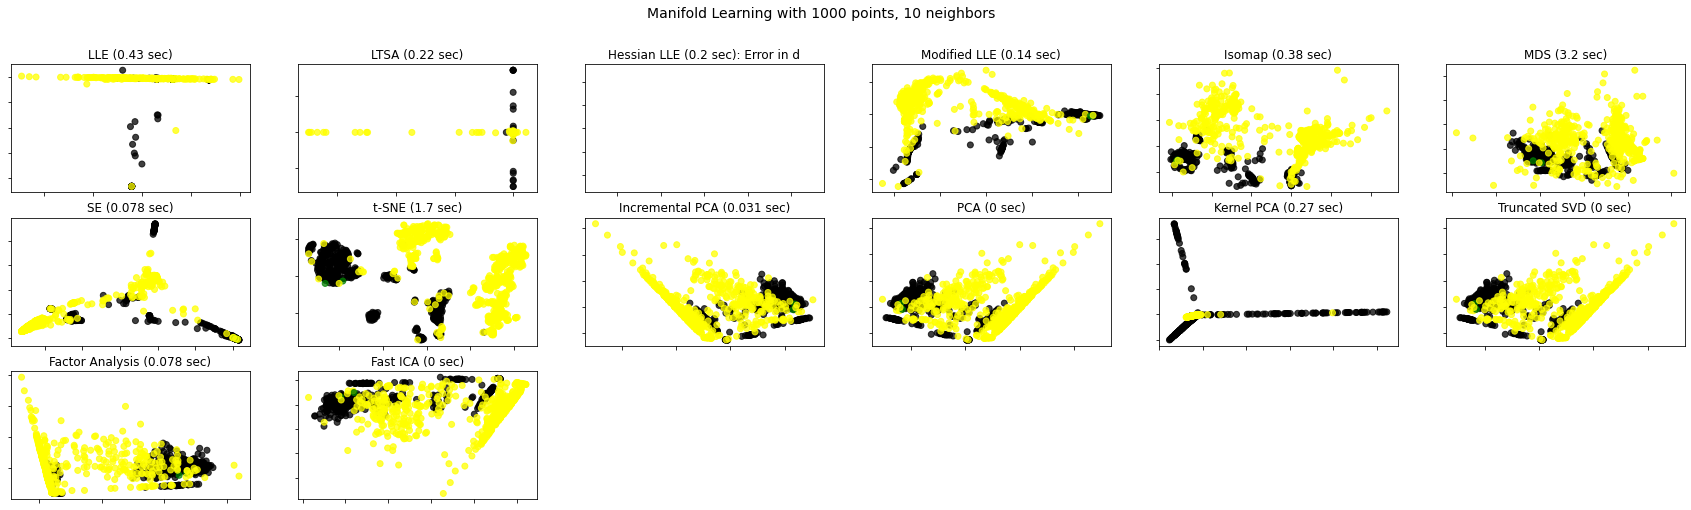

In [21]:

import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler

columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
sample_size = 1_000
mask_series = climates_df.index.isin(nearby_list)
df = climates_df[mask_series][columns_list]
if df.shape[0] < sample_size:
    df = df.append(climates_df[~mask_series][columns_list].sample(sample_size - df.shape[0]))
else:
    df = df.sample(sample_size)
colors_list = []
like_list = climates_df[climates_df.is_like_flagstaff].index
for idx in df.index:
    if idx in nearby_list:
        colors_list.append('black')
    elif idx in like_list:
        colors_list.append('green')
    else:
        colors_list.append('yellow')
X1 = df.fillna(0).values
scaler = StandardScaler().fit(X1)
X1_scaled = scaler.transform(X1)

# Create figure
fig = plt.figure(figsize=(30, 8))
fig.suptitle(
    'Manifold Learning with %i points, %i neighbors' % (sample_size, n_neighbors), fontsize=14
)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    ax = fig.add_subplot(3, 6, 1 + i)
    t0 = time()
    try:
        y1 = method.fit_transform(X1_scaled)
        t1 = time()
        ax.set_title('%s (%.2g sec)' % (label, t1 - t0))
        ax.scatter(y1[:, 0], y1[:, 1], c=colors_list, cmap=plt.cm.Spectral, alpha=0.75)
    except (SystemError, RuntimeError, ValueError) as e:
        t1 = time()
        ax.set_title('%s (%.2g sec): %s' % (label, t1 - t0, str(e).strip()[:10]))
        print(str(e).strip())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


----

In [23]:

# Get summary statement
near_count = climates_df[climates_df.distance_to_flagstaff < 0.2].shape[0]
like_count = climates_df[climates_df.is_like_flagstaff].shape[0]
total_count = climates_df.shape[0]
print(f'{near_count} stations near Flagstaff, {like_count:,} stations like Flagstaff, with {total_count:,} total weather stations')

443 stations near Flagstaff, 13,126 stations like Flagstaff, with 2,512,392 total weather stations


In [24]:

# Get ratio of like to unlike
climates_df.is_like_flagstaff.value_counts()

False    2499266
True       13126
Name: is_like_flagstaff, dtype: int64

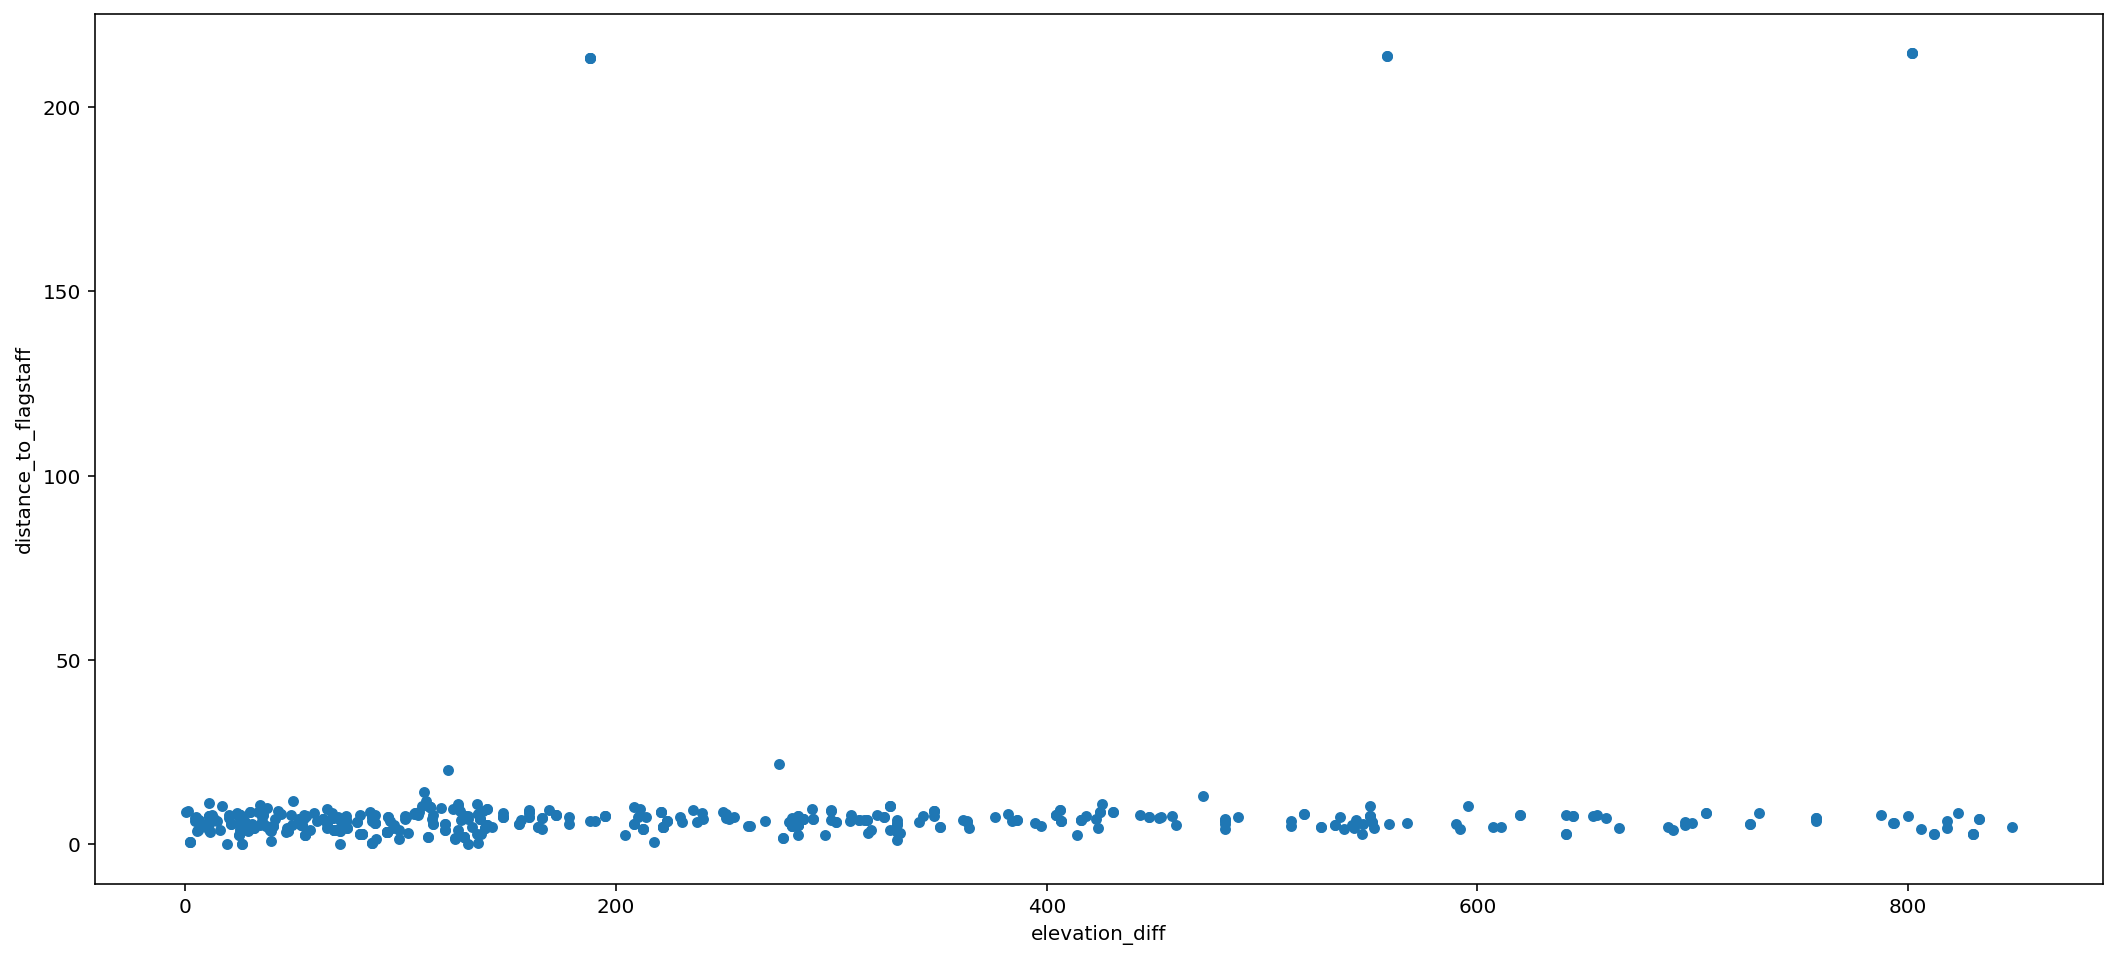

In [25]:

# Display a sample distribution of Flagstaff-like weather stations
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('retina')
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
AxesSubplot_obj = climates_df[climates_df.is_like_flagstaff].sample(500).plot(x='elevation_diff', y='distance_to_flagstaff', ax=ax, kind='scatter')

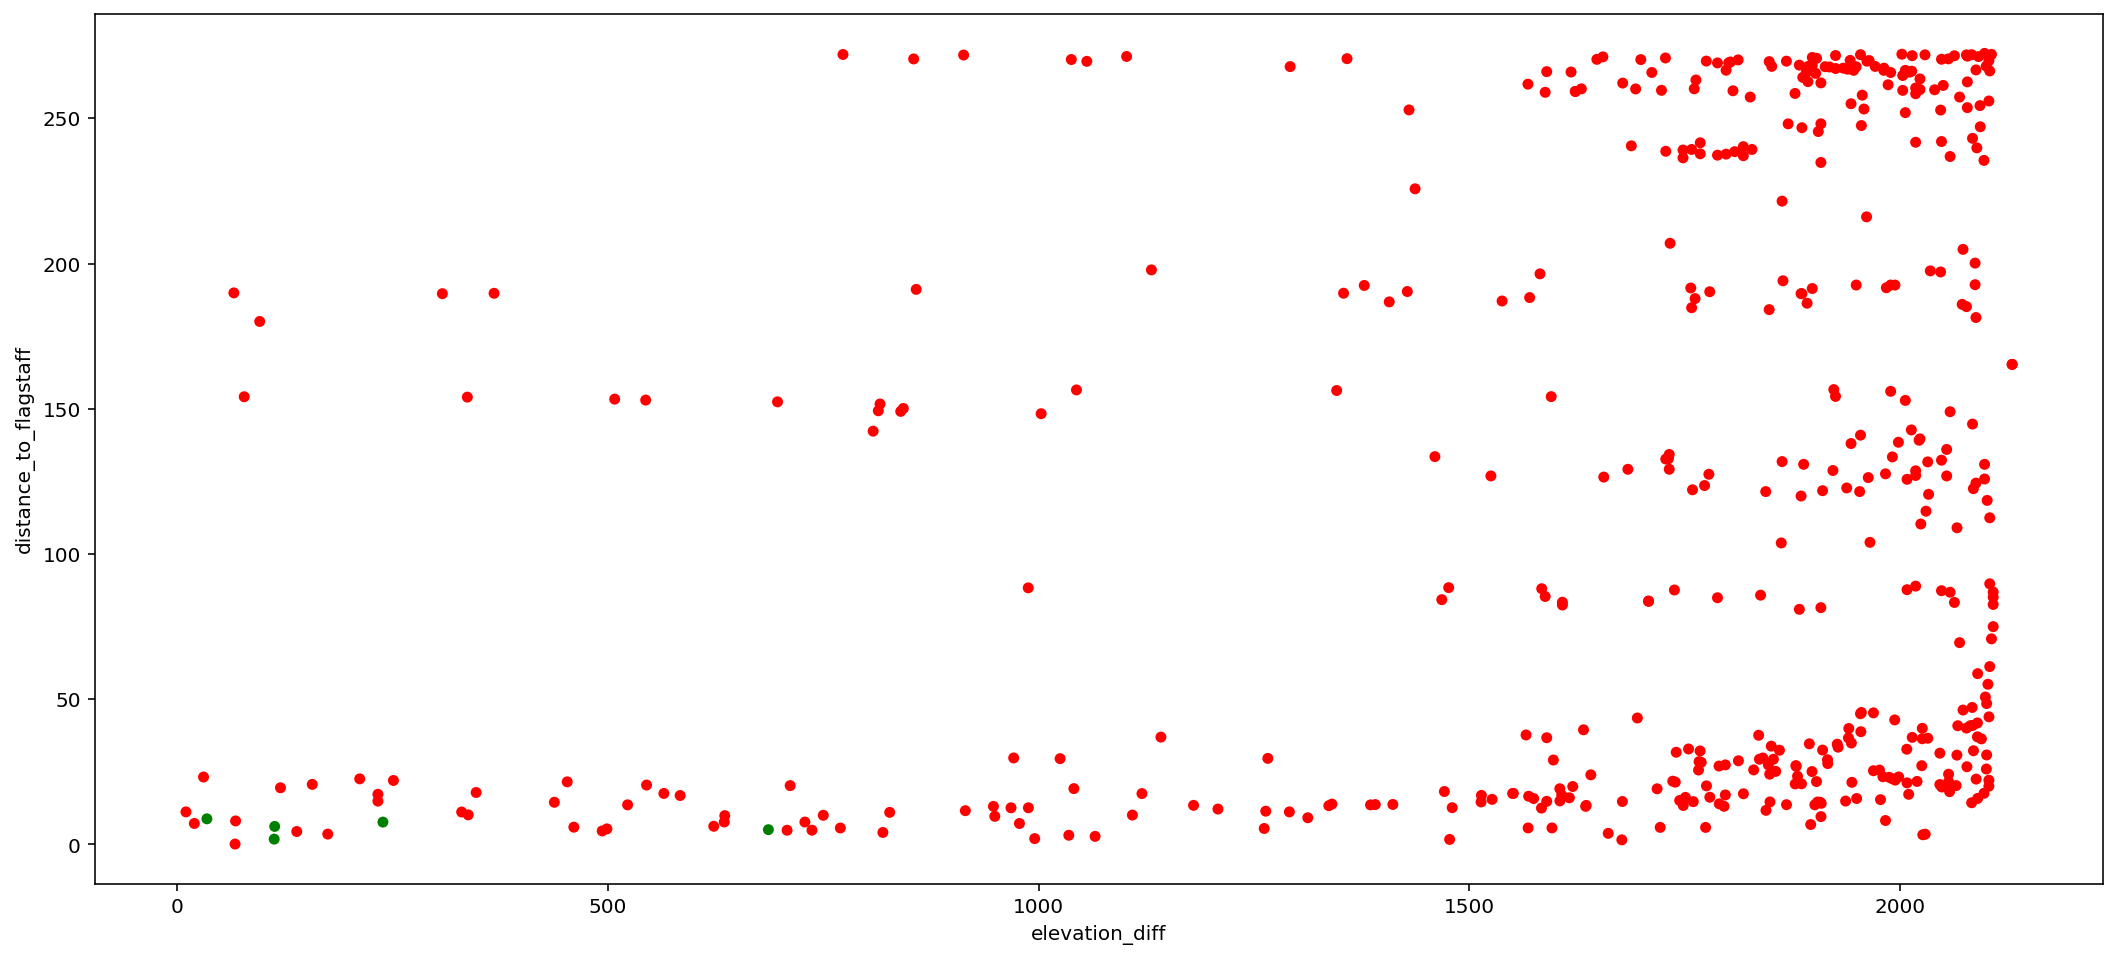

In [26]:

# Display a sample of the total distribution
df = climates_df.sample(500)
idx_list = df[df.is_like_flagstaff].index
colors_list = ['green' if x else 'red' for x in df.index.map(lambda x: x in idx_list)]
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, autoscale_on=True)
path_collection = df.plot(x='elevation_diff', y='distance_to_flagstaff', ax=ax, kind='scatter', c=colors_list)

In [27]:

climates_df.groupby('elevation_diff').distance_to_flagstaff.max().head(20)

elevation_diff
0.0    21.102102
0.3     8.802506
0.6     5.127756
0.9    19.623067
1.2    18.633362
1.8    16.746147
2.1    16.077287
2.4     7.942295
2.7    21.477546
3.0     3.615930
3.1    17.493024
3.3     5.773408
4.0    19.979073
4.3    46.848962
4.9    26.542465
5.2    16.426187
5.5     6.974672
5.8    18.139283
6.1    10.334515
6.4     6.713603
Name: distance_to_flagstaff, dtype: float64

In [28]:

climates_df.groupby('distance_to_flagstaff').elevation_diff.max().head(20)

distance_to_flagstaff
0.015466      2.1
0.033182     13.7
0.038253     11.0
0.041132     38.7
0.048086      7.0
0.051328      NaN
0.054129     16.5
0.056222     26.5
0.058317     25.6
0.073646      7.0
0.088039     63.7
0.106132    123.1
0.113344     29.3
0.114066    132.3
0.115094    131.4
0.130167     66.1
0.136357     34.1
0.141722    857.7
0.144000     67.4
0.147351     19.5
Name: elevation_diff, dtype: float64

In [29]:

# Get the Wikipedia articles near Flagstaff, AZ, USA
# Latitude and longitude coordinates are: 35.198284, -111.651299
import wikipedia

# print([f'wikipedia.{fn}' for fn in dir(wikipedia) if not fn.startswith('_')])
flagstaff_latitude = 35.198284
flagstaff_longitude = -111.651299
wikipedia.geosearch(latitude=flagstaff_latitude, longitude=flagstaff_longitude)

['Orpheum Theater (Flagstaff, Arizona)', 'Flagstaff station', 'Weatherford Hotel', 'First Baptist Church (Flagstaff, Arizona)', 'Our Lady of Guadaloupe Church', 'Hotel Monte Vista', 'Downtown Flagstaff, Arizona', 'Presbyterian Church Parsonage (Flagstaff, Arizona)', 'Brannen-Devine House', 'Flagstaff High School']

In [30]:

import webbrowser

mask_series = climates_df.is_like_flagstaff & ~climates_df.wikipedia_url.isnull()
df = climates_df[mask_series].sort_values('distance_to_flagstaff', ascending=False)
for row_index, row_series in df.loc[df.NAME.shift(-1) != df.NAME].head(3).iterrows():
    latitude = row_series.LATITUDE
    longitude = row_series.LONGITUDE
    titles_list = wikipedia.geosearch(latitude=latitude, longitude=longitude, radius=1_000)
    if titles_list:
        wikipedia_url = wikipedia.page(title=titles_list[0]).url
        # climates_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
        webbrowser.open(wikipedia_url, new=2)


# Make a Bounding Box around Australia

In [31]:

# From https://en.wikipedia.org/wiki/List_of_extreme_points_of_Australia
from dms2dec.dms_convert import dms2dec

northernmost_latitude = dms2dec('''9°8'23" S''')
southernmost_latitude = dms2dec('''55°03' S''')
easternmost_longitude = dms2dec('''167°57' E''')
westernmost_longitude = dms2dec('''72°34' E''')
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,wikipedia_url


In [32]:

# Use the Random Forest predictions (takes about 12 hours)
if 'is_like_flagstaff' not in climates_df.columns:
    tqdm.pandas()
    numeric_columns_list = s.load_object('numeric_columns_list')
    rfclf = s.load_object('rfclf')
    def f(row_series):

        # Reshape your data using array.reshape(1, -1) if your data contains a single sample
        X = row_series[numeric_columns_list].fillna(0).values.reshape(1, -1)

        return rfclf.predict(X)[0]
    climates_df['is_like_flagstaff'] = climates_df.progress_apply(f, axis='columns')